# OnlySolution's A/B Testing Business Case
An analysis based on A/B testing on rating bar redesign. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Prepare the data

In [2]:
# Read the data
df = pd.read_csv('data/rating-bar-dataset.csv')

# Drop rows filled with NaN values
df.dropna(how='all', inplace=True)

# Reaplce NaN values with zeros
df.fillna(0, inplace=True)

cols = []

for i in range(1, 13):
    cols += [f'M{i}Pay', f'M{i}Ref']

df.columns = ['CustomerID', 'Device', 'Medium', 'Date', 'Category', 'TrialPay', 'TrialRef', *cols, 'Rated', 'Experiment']

# Convert date strings to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

## Add necessary columns and remove unnecessay ones

In [3]:
# Add columns 'Payments' and 'Refunds' for total sums of payments and refunds
df['Payments'] = df.loc[:, 'TrialPay':'M12Pay':2].sum(axis=1)
df['Refunds'] = df.loc[:, 'TrialRef':'M12Ref':2].sum(axis=1)

# Calculate LTV per customer based on new data
df['LTV'] = df['Payments'] - df['Refunds']

# Remove unused columns from the DataFrame
df.drop(df.loc[:, 'CustomerID':'Medium'], inplace=True, axis=1)
df.drop(df.loc[:, 'Category':'M12Ref'], inplace=True, axis=1)
df.drop(df.loc[:, 'Payments':'Refunds'], inplace=True, axis=1)

## Define function for plotting data

In [4]:
def plot_prop(df: pd.DataFrame, prop: str, title: str, ylabel: str, approximation=2):
    """
    Plot a certain property throughout time.
    """
    plt.figure(figsize=(15,5))
    plt.style.use('ggplot')
    
    indices = list(set(index[0] for index in df.index))
    
    for index in indices:
        df.loc[index][prop].rolling(approximation).mean().plot()

    plt.legend(indices)

    # plt.xticks(np.arange(1, 11), labels=["jan","feb","mar","apr","may","jun","jul","aug","sep","oct"])

    plt.title(title)
    plt.xlabel('')
    plt.ylabel(ylabel)

    plt.show()

## Check if A/B customer groups are similar

In [5]:
# Split customers into 3 groups: control, experiment and others
control = df.loc[df['Experiment'] == 'Control']
experiment = df.loc[df['Experiment'] == 'Variation']
non_experiment = df.loc[df['Experiment'] == 'Not an Experiment']

In [6]:
# Compare mean LTV between groups
control['LTV'].mean(), experiment['LTV'].mean(), non_experiment['LTV'].mean()

(9.996883116883131, 10.05438144329898, 10.433963702913088)

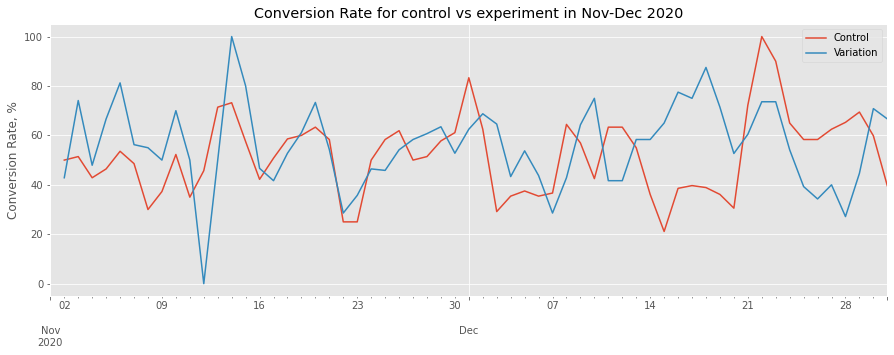

In [7]:
# Calculate conversion rate for each date
experiment_only = df.loc[~(df['Experiment'] == 'Not an Experiment')]
experiment_only.insert(0, 'Count', 1)
sums = experiment_only.groupby(['Experiment', 'Date']).sum()
sums['Conversion rate'] = sums['Rated'] / sums['Count'] * 100

# Plot the data
plot_prop(sums, 'Conversion rate', 'Conversion Rate for control vs experiment in Nov-Dec 2020', 'Conversion Rate, %')

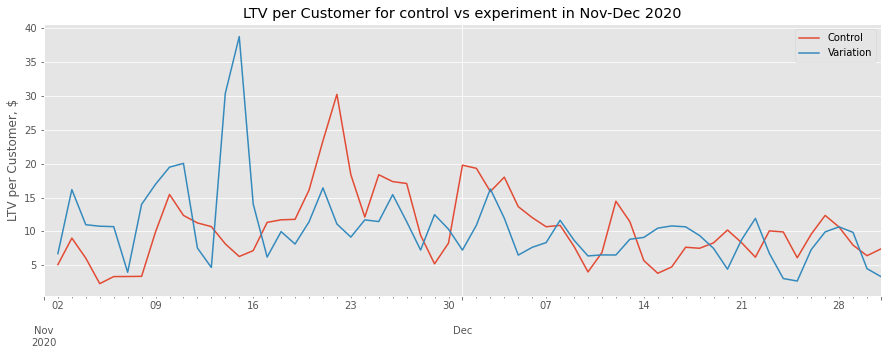

In [8]:
# Calculate mean LTV per customer for each date
sums['LTV'] /= sums['Count']

# Plot the data
plot_prop(sums, 'LTV', 'LTV per Customer for control vs experiment in Nov-Dec 2020', 'LTV per Customer, $')

As we can see, mean LTV is almost equal for groups A and B, and they both have a quite close mean LTV in comparison with customers that were not involved in the experiment. It means that the experiment is accurate.

## Calculate confidence interval for the experiment

In [9]:
# Create a DataFrame to store results of calculations
calculations = pd.DataFrame(index=['Control', 'Experiment'])

In [10]:
# Calculate conversion for control and experiment
control = df.loc[df['Experiment'] == 'Control']['Rated']
experiment = df.loc[df['Experiment'] == 'Variation']['Rated']

control_conversion = (control.value_counts() / control.shape[0])[1]
experiment_conversion = (experiment.value_counts() / experiment.shape[0])[1]

calculations['Conversion'] = [round(control_conversion, 3), round(experiment_conversion, 3)]

print('Control conversion:', round(control_conversion, 3))
print('Experiment conversion:', round(experiment_conversion, 3))

Control conversion: 0.519
Experiment conversion: 0.572


In [11]:
# Calculate lift value
lift = experiment_conversion / control_conversion - 1

print(f'Lift: {round(lift, 4) * 100}%')

Lift: 10.14%


![Expected Lift for Experiment](img/lift.jpg)

In [12]:
# Calculate standard error for control and experiment
control_std_error = (control_conversion * (1 - control_conversion) / control.shape[0]) ** 0.5
experiment_std_error = (experiment_conversion * (1 - experiment_conversion) / experiment.shape[0]) ** 0.5

calculations['Standard error'] = [round(control_std_error, 6), round(experiment_std_error, 6)]

print('Control standard error:', round(control_std_error, 6))
print('Experiment standard error:', round(experiment_std_error, 6))

Control standard error: 0.025463
Experiment standard error: 0.025118


![Standard Error for Control](img/control_standard_error.jpg)
![Standard Error for Experiment](img/experiment_standard_error.jpg)

In [13]:
# Calculate lift variance for control and experiment
experiment_lift_variance = ((experiment_conversion / control_conversion) ** 2 * 
                            (control_std_error ** 2 / control_conversion ** 2 + 
                             experiment_std_error ** 2 / experiment_conversion ** 2))

calculations['Lift variance'] = [np.NAN, round(experiment_lift_variance, 6)]
    
print('Experiment lift variance', round(experiment_lift_variance, 6))

Experiment lift variance 0.005253


![Lift Variance for Experiment](img/experiment_lift_variance.jpg)

In [14]:
# Calculate lower and upper bound for the experiment [t-value is equal to 1.645]
t_value = 1.645

experiment_lower_bound = lift - t_value * experiment_lift_variance ** 0.5
experiment_upper_bound = lift + t_value * experiment_lift_variance ** 0.5

calculations['Lower bound'] = [np.NaN, f'{round(experiment_lower_bound, 4) * 100}%']
calculations['Upper bound'] = [np.NaN, f'{round(experiment_upper_bound, 4) * 100}%']

print(f'Confidence Interval: [{round(experiment_lower_bound, 4) * 100}%, {round(experiment_upper_bound, 4) * 100}%]')

Confidence Interval: [-1.78%, 22.06%]


![Bounds for Experiment](img/experiment_lift_bounds.jpg)

As we can see, confidence interval crosses 0 as its low bound is equal to -1.7%. Therefore, we cannot say if the difference in conversion rate is significant. The test is not winner.